# カートポール問題を多層ニューラルネットワークで解く

In [14]:
import gym
import tensorflow as tf
import numpy as np

## 環境の読み込み

In [15]:
env = gym.make('CartPole-v0')

## ネットワークのクラス定義

クラスとは、命令や変数をまとめたデータのかたまりです。

１つのクラスオブジェクトに複数のデータを格納し、操作をすることが可能です。

In [16]:
class QNetwork:
    def __init__(self,learning_rate=0.01,state_size=4,action_size=2,hidden_size=10,name='QNetwork'):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32,[None,state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32,[None],name='actions')
            one_hot_actions = tf.one_hot(self.actions_,action_size)
            self.targetQs_ = tf.placeholder(tf.float32,[None],name='target')
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_,hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1,hidden_size)
            self.output = tf.contrib.layers.fully_connected(self.fc2,action_size,activation_fn=None)
            self.Q = tf.reduce_sum(tf.multiply(self.output,one_hot_actions),axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## エクスペリエンス・メモリの定義

In [17]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## ハイパーパラメーターの定義と初期化

In [18]:
train_episodes = 1000
max_step = 200
gamma = 0.99

explore_start = 1.0
explore_stop = 0.01
decay_rate = 0.0001

hidden_size = 64
learning_rate = 0.0001

memory_size = 10000
batch_size = 20
pretrain_length = batch_size

In [19]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## エクスペリエンスメモリーを埋めよう

In [20]:
env.reset()

state,reward,done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

for ii in range(pretrain_length):
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.add((state,action,reward,next_state))
        
        env.reset()
        
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        memory.add((state, action, reward, next_state))
        state = next_state

## トレーニング

In [21]:
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_rewards = 0
        t = 0
        while t < max_step:
            step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                feed = {mainQN.inputs_: state.reshape((1,*state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                
            next_state, reward, done, _ = env.step(action)
            total_rewards += reward
            
            if done:
                next_state = np.zeros(state.shape)
                t = max_step
                
                # if ep % 100 == 0:
                print('Episode: {}'.format(ep),'Total Reward: {}'.format(total_rewards),
                     'Total Loss: {:.4f}'.format(loss), 'Explore Prob: {:.4f}'.format(explore_p))
                    
                rewards_list.append((ep, total_rewards))
                memory.add((state, action, reward, next_state))
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
            
            else:
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
                
            batch = memory.sample(batch_size)
            # print(batch)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            episode_ends = (next_states == np.zeros(state[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.opt], 
                              feed_dict={mainQN.inputs_: states,
                                        mainQN.targetQs_: targets,
                                        mainQN.actions_: actions})
            
    saver.save(sess, "checkpoints/cartpole_dqn.ckpt")

Episode: 1 Total Reward: 11.0 Total Loss: 1.0527 Explore Prob: 0.9989
Episode: 2 Total Reward: 11.0 Total Loss: 1.0274 Explore Prob: 0.9978
Episode: 3 Total Reward: 36.0 Total Loss: 1.0078 Explore Prob: 0.9943
Episode: 4 Total Reward: 21.0 Total Loss: 1.0061 Explore Prob: 0.9922
Episode: 5 Total Reward: 12.0 Total Loss: 1.1057 Explore Prob: 0.9910
Episode: 6 Total Reward: 11.0 Total Loss: 0.9928 Explore Prob: 0.9900
Episode: 7 Total Reward: 14.0 Total Loss: 1.0527 Explore Prob: 0.9886
Episode: 8 Total Reward: 19.0 Total Loss: 1.0918 Explore Prob: 0.9867
Episode: 9 Total Reward: 12.0 Total Loss: 1.0781 Explore Prob: 0.9856
Episode: 10 Total Reward: 17.0 Total Loss: 1.1518 Explore Prob: 0.9839
Episode: 11 Total Reward: 23.0 Total Loss: 1.0839 Explore Prob: 0.9817
Episode: 12 Total Reward: 9.0 Total Loss: 0.9604 Explore Prob: 0.9808
Episode: 13 Total Reward: 91.0 Total Loss: 1.1746 Explore Prob: 0.9720
Episode: 14 Total Reward: 25.0 Total Loss: 1.3998 Explore Prob: 0.9696
Episode: 15 Tota

Episode: 118 Total Reward: 24.0 Total Loss: 38.8347 Explore Prob: 0.7843
Episode: 119 Total Reward: 21.0 Total Loss: 1.5482 Explore Prob: 0.7827
Episode: 120 Total Reward: 13.0 Total Loss: 120.2850 Explore Prob: 0.7817
Episode: 121 Total Reward: 18.0 Total Loss: 1.5391 Explore Prob: 0.7803
Episode: 122 Total Reward: 20.0 Total Loss: 75.6641 Explore Prob: 0.7788
Episode: 123 Total Reward: 71.0 Total Loss: 33.5490 Explore Prob: 0.7733
Episode: 124 Total Reward: 11.0 Total Loss: 50.3233 Explore Prob: 0.7725
Episode: 125 Total Reward: 20.0 Total Loss: 34.7780 Explore Prob: 0.7710
Episode: 126 Total Reward: 24.0 Total Loss: 67.5027 Explore Prob: 0.7692
Episode: 127 Total Reward: 17.0 Total Loss: 32.3224 Explore Prob: 0.7679
Episode: 128 Total Reward: 10.0 Total Loss: 115.1722 Explore Prob: 0.7671
Episode: 129 Total Reward: 12.0 Total Loss: 1.5274 Explore Prob: 0.7662
Episode: 130 Total Reward: 11.0 Total Loss: 55.9313 Explore Prob: 0.7654
Episode: 131 Total Reward: 11.0 Total Loss: 0.8792 E

Episode: 234 Total Reward: 43.0 Total Loss: 20.8351 Explore Prob: 0.6357
Episode: 235 Total Reward: 22.0 Total Loss: 1.0100 Explore Prob: 0.6343
Episode: 236 Total Reward: 36.0 Total Loss: 15.6518 Explore Prob: 0.6320
Episode: 237 Total Reward: 25.0 Total Loss: 19.9009 Explore Prob: 0.6305
Episode: 238 Total Reward: 34.0 Total Loss: 1.1808 Explore Prob: 0.6284
Episode: 239 Total Reward: 15.0 Total Loss: 1.6201 Explore Prob: 0.6275
Episode: 240 Total Reward: 26.0 Total Loss: 52.0502 Explore Prob: 0.6259
Episode: 241 Total Reward: 8.0 Total Loss: 18.0036 Explore Prob: 0.6254
Episode: 242 Total Reward: 21.0 Total Loss: 26.1847 Explore Prob: 0.6241
Episode: 243 Total Reward: 15.0 Total Loss: 18.1454 Explore Prob: 0.6231
Episode: 244 Total Reward: 21.0 Total Loss: 1.0951 Explore Prob: 0.6219
Episode: 245 Total Reward: 43.0 Total Loss: 16.9924 Explore Prob: 0.6192
Episode: 246 Total Reward: 34.0 Total Loss: 65.9197 Explore Prob: 0.6172
Episode: 247 Total Reward: 66.0 Total Loss: 1.0779 Explo

Episode: 349 Total Reward: 28.0 Total Loss: 51.5525 Explore Prob: 0.4015
Episode: 350 Total Reward: 53.0 Total Loss: 1.0811 Explore Prob: 0.3994
Episode: 351 Total Reward: 75.0 Total Loss: 44.3566 Explore Prob: 0.3965
Episode: 352 Total Reward: 63.0 Total Loss: 1.1947 Explore Prob: 0.3941
Episode: 353 Total Reward: 75.0 Total Loss: 1.9460 Explore Prob: 0.3912
Episode: 354 Total Reward: 56.0 Total Loss: 31.1437 Explore Prob: 0.3891
Episode: 355 Total Reward: 30.0 Total Loss: 2.9129 Explore Prob: 0.3879
Episode: 356 Total Reward: 99.0 Total Loss: 2.1988 Explore Prob: 0.3842
Episode: 357 Total Reward: 68.0 Total Loss: 1.7551 Explore Prob: 0.3817
Episode: 358 Total Reward: 52.0 Total Loss: 2.6253 Explore Prob: 0.3797
Episode: 359 Total Reward: 57.0 Total Loss: 1.3622 Explore Prob: 0.3776
Episode: 360 Total Reward: 49.0 Total Loss: 32.4305 Explore Prob: 0.3758
Episode: 361 Total Reward: 57.0 Total Loss: 93.6233 Explore Prob: 0.3738
Episode: 362 Total Reward: 61.0 Total Loss: 73.0534 Explore

Episode: 462 Total Reward: 199.0 Total Loss: 0.3680 Explore Prob: 0.0987
Episode: 463 Total Reward: 183.0 Total Loss: 0.1745 Explore Prob: 0.0971
Episode: 464 Total Reward: 199.0 Total Loss: 0.2500 Explore Prob: 0.0954
Episode: 465 Total Reward: 199.0 Total Loss: 291.7346 Explore Prob: 0.0937
Episode: 466 Total Reward: 183.0 Total Loss: 0.4114 Explore Prob: 0.0922
Episode: 467 Total Reward: 199.0 Total Loss: 0.3477 Explore Prob: 0.0906
Episode: 468 Total Reward: 199.0 Total Loss: 0.3855 Explore Prob: 0.0890
Episode: 469 Total Reward: 199.0 Total Loss: 0.0947 Explore Prob: 0.0874
Episode: 470 Total Reward: 199.0 Total Loss: 0.2820 Explore Prob: 0.0859
Episode: 471 Total Reward: 199.0 Total Loss: 0.3691 Explore Prob: 0.0844
Episode: 472 Total Reward: 144.0 Total Loss: 0.5787 Explore Prob: 0.0834
Episode: 473 Total Reward: 199.0 Total Loss: 0.5028 Explore Prob: 0.0819
Episode: 474 Total Reward: 199.0 Total Loss: 0.3157 Explore Prob: 0.0805
Episode: 475 Total Reward: 192.0 Total Loss: 0.45

Episode: 576 Total Reward: 158.0 Total Loss: 0.5501 Explore Prob: 0.0259
Episode: 577 Total Reward: 57.0 Total Loss: 0.3614 Explore Prob: 0.0258
Episode: 578 Total Reward: 55.0 Total Loss: 263.2764 Explore Prob: 0.0257
Episode: 579 Total Reward: 93.0 Total Loss: 66.9811 Explore Prob: 0.0256
Episode: 580 Total Reward: 199.0 Total Loss: 0.6782 Explore Prob: 0.0253
Episode: 581 Total Reward: 55.0 Total Loss: 0.3524 Explore Prob: 0.0252
Episode: 582 Total Reward: 61.0 Total Loss: 0.2980 Explore Prob: 0.0251
Episode: 583 Total Reward: 72.0 Total Loss: 0.4587 Explore Prob: 0.0250
Episode: 584 Total Reward: 170.0 Total Loss: 0.5059 Explore Prob: 0.0247
Episode: 585 Total Reward: 58.0 Total Loss: 0.5258 Explore Prob: 0.0246
Episode: 586 Total Reward: 60.0 Total Loss: 0.5195 Explore Prob: 0.0246
Episode: 587 Total Reward: 95.0 Total Loss: 249.0426 Explore Prob: 0.0244
Episode: 588 Total Reward: 195.0 Total Loss: 0.2091 Explore Prob: 0.0241
Episode: 589 Total Reward: 88.0 Total Loss: 0.1718 Expl

Episode: 689 Total Reward: 199.0 Total Loss: 0.2835 Explore Prob: 0.0129
Episode: 690 Total Reward: 199.0 Total Loss: 0.2030 Explore Prob: 0.0129
Episode: 691 Total Reward: 199.0 Total Loss: 0.1765 Explore Prob: 0.0128
Episode: 692 Total Reward: 199.0 Total Loss: 0.2646 Explore Prob: 0.0128
Episode: 693 Total Reward: 199.0 Total Loss: 0.3902 Explore Prob: 0.0127
Episode: 694 Total Reward: 199.0 Total Loss: 0.2681 Explore Prob: 0.0127
Episode: 695 Total Reward: 199.0 Total Loss: 0.3431 Explore Prob: 0.0126
Episode: 696 Total Reward: 199.0 Total Loss: 159.7393 Explore Prob: 0.0126
Episode: 697 Total Reward: 199.0 Total Loss: 0.8235 Explore Prob: 0.0125
Episode: 698 Total Reward: 199.0 Total Loss: 0.1610 Explore Prob: 0.0125
Episode: 699 Total Reward: 199.0 Total Loss: 0.5091 Explore Prob: 0.0124
Episode: 700 Total Reward: 199.0 Total Loss: 0.8152 Explore Prob: 0.0124
Episode: 701 Total Reward: 199.0 Total Loss: 0.4275 Explore Prob: 0.0123
Episode: 702 Total Reward: 199.0 Total Loss: 0.44

Episode: 804 Total Reward: 10.0 Total Loss: 3.9922 Explore Prob: 0.0105
Episode: 805 Total Reward: 9.0 Total Loss: 871.8908 Explore Prob: 0.0105
Episode: 806 Total Reward: 12.0 Total Loss: 3.1591 Explore Prob: 0.0105
Episode: 807 Total Reward: 9.0 Total Loss: 3.7107 Explore Prob: 0.0105
Episode: 808 Total Reward: 13.0 Total Loss: 3.0150 Explore Prob: 0.0105
Episode: 809 Total Reward: 10.0 Total Loss: 1.8945 Explore Prob: 0.0105
Episode: 810 Total Reward: 12.0 Total Loss: 2.8322 Explore Prob: 0.0105
Episode: 811 Total Reward: 12.0 Total Loss: 2.0658 Explore Prob: 0.0105
Episode: 812 Total Reward: 13.0 Total Loss: 1.6494 Explore Prob: 0.0105
Episode: 813 Total Reward: 17.0 Total Loss: 1.6384 Explore Prob: 0.0105
Episode: 814 Total Reward: 11.0 Total Loss: 2.2722 Explore Prob: 0.0105
Episode: 815 Total Reward: 12.0 Total Loss: 2.5908 Explore Prob: 0.0105
Episode: 816 Total Reward: 15.0 Total Loss: 0.9849 Explore Prob: 0.0105
Episode: 817 Total Reward: 16.0 Total Loss: 512.8981 Explore Pro

Episode: 917 Total Reward: 199.0 Total Loss: 4.8123 Explore Prob: 0.0102
Episode: 918 Total Reward: 199.0 Total Loss: 3.5977 Explore Prob: 0.0102
Episode: 919 Total Reward: 199.0 Total Loss: 1.1134 Explore Prob: 0.0102
Episode: 920 Total Reward: 199.0 Total Loss: 4.3702 Explore Prob: 0.0102
Episode: 921 Total Reward: 199.0 Total Loss: 2.7729 Explore Prob: 0.0102
Episode: 922 Total Reward: 199.0 Total Loss: 0.9352 Explore Prob: 0.0102
Episode: 923 Total Reward: 199.0 Total Loss: 2.8220 Explore Prob: 0.0102
Episode: 924 Total Reward: 199.0 Total Loss: 355.9415 Explore Prob: 0.0102
Episode: 925 Total Reward: 199.0 Total Loss: 0.6334 Explore Prob: 0.0102
Episode: 926 Total Reward: 199.0 Total Loss: 1.1060 Explore Prob: 0.0102
Episode: 927 Total Reward: 199.0 Total Loss: 3.1621 Explore Prob: 0.0102
Episode: 928 Total Reward: 199.0 Total Loss: 1.2355 Explore Prob: 0.0102
Episode: 929 Total Reward: 199.0 Total Loss: 0.7917 Explore Prob: 0.0102
Episode: 930 Total Reward: 199.0 Total Loss: 228.

## トレーニングの結果を可視化しよう

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x,0,0))
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Rewards')

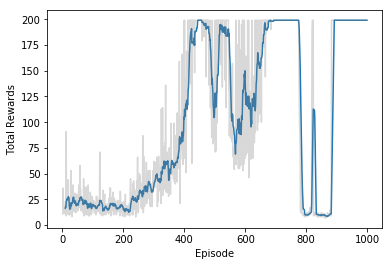

In [ ]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews,10)
plt.plot(eps[-len(smoothed_rews):],smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Rewards')

In [ ]:
test_episodes = 1000
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render()
            
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints\cartpole_dqn.ckpt
